In [75]:
import pandas as pd
from tabulate import tabulate as T
from matplotlib import pyplot as plt

## LOAD DATA

In [76]:
df = pd.read_csv("datasets\\train.csv")

Arquivo a ser predito e submetido para a
[competição do Kaggle](https://www.kaggle.com/competitions/am-2022-1-paciente-saudvel-ou-no/leaderboard) da disciplina de Aprendizado de Máquina (PUCRS)

In [77]:
test = pd.read_csv("datasets\\test.csv")
test_ids = test['id'] 

<img src="https://raw.githubusercontent.com/adilsonmedronha/Classification_problems/main/Vertebral%20Column/assets/comp-overview.png" alt="Drawing" style="width: 400px;"/>

**Uma observação importantíssima:** <br>

O dataset de treino foi treinado (como verás) com o ID sendo uma feature, (eu sei) em termos práticos isso não faz sentido, pois IDs nada agregam para dizer se algum indivíduo está **ou normal ou com hernia ou com espondilite**. E pior, esse acréscimo aumenta a dimensão do problema (de seis para sete), <br>

Entretanto, o modelo que avalia a competição do Kaggle foi treinado considerando o ID. Logo, se o ID não for utilizado neste treinamento, acho pouquíssimo provável atingir uma acurácia igual ou superior a $80\%$. Como o objetivo é chegar o mais perto de $100\%$, vamos jogar com as cartas certas.

In [78]:
# variavel alvo
y = df["class"]

In [79]:
# removendo a variavel alvo, pois y nao eh uma feature, mas sim o conjunto
# de classes, que eh exatamente o que queremos estimar dado as features que 
# agora estao em df
df = df.drop(["class"], axis=1)

## FEATURE ENGINEERING

In [80]:
# visao geral das features 
# (sim, e o ID, inutilmente)
df.describe()

,id,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,154.105991,60.458343,17.541355,52.660081,42.916988,118.073520,27.715448
std,89.472388,18.045677,10.786425,19.226267,13.631236,13.920744,40.965137
min,1.000000,26.147921,-6.554948,14.000000,13.516568,70.082575,-11.058179
25%,79.000000,46.236399,9.976664,36.329137,33.366366,110.660701,1.517203
50%,158.000000,57.145851,16.417462,51.000000,42.447102,118.151531,13.683047
75%,229.000000,74.469082,22.432950,63.232302,51.766175,126.398188,49.159426
max,308.000000,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


### IMBALANCED CLASS

Será que as classes estão desbalanceadas?

In [81]:
classes = y[0], y[1], y[2]
quantity = y.value_counts()

<BarContainer object of 3 artists>

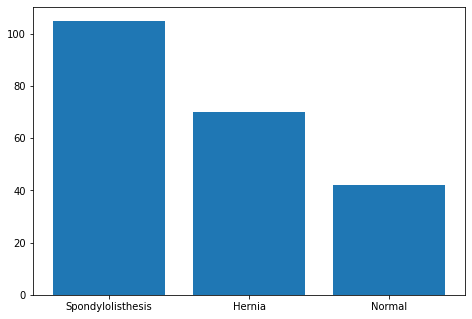

In [82]:
fig = plt.figure()
ax  = fig.add_axes([0, 0, 1, 1])
ax.bar(classes, quantity)

Sim, claramente não temos a mesma proporção de classes. <br> 
Veja que a classe majoritária (Spondylolisthesis) é exatamente $2.5$ vezes maior que a classe minoritária (Normal). <br>

Observado isso, eu vou utilizar um equalizador de classes, veja o código a seguir.

### OVERSAMPLE

É uma técnica que insere viés, pois compensamos o desbalanceamento das classes com a inserção de novos exemplos (minoritários) até atingir o número de amostras da classe majoritária.

In [83]:
from collections import Counter
print('#classes do dataset original: \n', Counter(y))

#classes do dataset original: 
 Counter({'Spondylolisthesis': 105, 'Normal': 70, 'Hernia': 42})


In [84]:
from imblearn.over_sampling import SMOTE 

X  = df

sm = SMOTE(random_state=42)
X_oversampled, y_oversampled = sm.fit_resample(X, y)

print('#classes do dataset reamostrado \n', Counter(y_oversampled))

#classes do dataset reamostrado 
 Counter({'Spondylolisthesis': 105, 'Hernia': 105, 'Normal': 105})


Como está ilustrado, agora as três classes tem a mesma quantidade de amostras:

<BarContainer object of 3 artists>

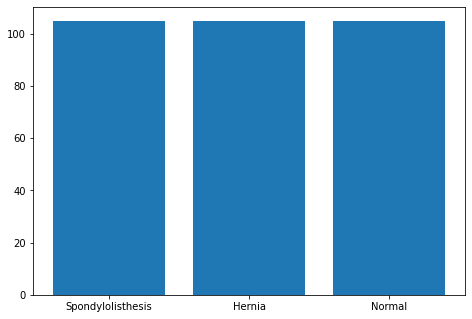

In [85]:
classes = y_oversampled[0], y_oversampled[1], y_oversampled[2]
quantity = y_oversampled.value_counts()
fig = plt.figure()
ax  = fig.add_axes([0, 0, 1, 1])
ax.bar(classes, quantity)

## NORMALIZATION

Primeiro, por que normalizar? Simplesmente pelo fato de que as features com medidas (escalas) divergentes **NÃO** contribuem igualmente para o modelo. <br> *E não necessariamente valores maiores são mais importantes.* Logo, queremos que todas as features tenham a mesma chance de influenciar o modelo paramétrico. Caso contrário, **os valores maiores sobreporiam os menores...** 

Para tanto, avaliei esses dois tipos de normalização
* [Min max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
* [Standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

### MIN MAX SCALER

In [86]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

# X normalizado 
x_scaled = min_max_scaler.fit_transform(X_oversampled.values) # usando com ID
X_normalized = pd.DataFrame(x_scaled)

# test normalizado
t_scaled = min_max_scaler.fit_transform(test.values) # chamar apenas transform
test = pd.DataFrame(t_scaled)

In [60]:
# observe que X_normalized contem as 315 features, pois foi reamostrado
# entao eh um reamostrado normalizado :)
X_normalized

,0,1,2,3,4,5,6
0,0.364821,0.420584,0.461434,0.308746,0.342506,0.284001,0.144850
1,0.166124,0.232063,0.648636,0.197812,0.064246,0.625991,0.039103
2,0.934853,0.466958,0.397938,0.399299,0.420006,0.379990,0.027135
3,0.664495,0.520452,0.723338,0.636299,0.302582,0.596967,0.259195
4,0.208469,0.557308,0.854509,0.429559,0.269941,0.483176,0.087631
...,...,...,...,...,...,...,...
310,0.957655,0.151606,0.350670,0.236308,0.141530,0.659503,0.019813
311,0.908795,0.365343,0.382953,0.279623,0.330145,0.598689,0.026196
312,0.804560,0.359214,0.554069,0.398261,0.235479,0.503727,0.048572
313,0.941368,0.244446,0.372903,0.200249,0.219198,0.493823,0.041469


In [87]:
test

,0,1,2,3,4,5,6
0,0.226537,0.662411,0.455232,0.431605,0.639010,0.601226,0.255043
1,0.427184,0.616578,0.535698,0.442024,0.537034,0.562102,0.400070
2,0.799353,0.307352,0.441265,0.105429,0.301477,0.637914,0.062200
3,0.061489,0.180868,0.344764,0.134276,0.246212,0.558544,0.042033
4,0.320388,0.443135,0.380679,0.288466,0.477362,0.541019,0.244054
...,...,...,...,...,...,...,...
88,0.326861,0.777645,0.485133,0.585341,0.730547,0.529110,0.296109
89,0.854369,0.380379,0.227773,0.363652,0.524505,0.480080,0.021837
90,0.491909,0.519400,0.384835,0.379102,0.549042,0.482123,0.252973
91,0.077670,0.093335,0.570919,0.119020,0.000000,0.542039,0.029304


### STANDARD SCALER

In [62]:
from sklearn.preprocessing import StandardScaler

standard_scaler = preprocessing.StandardScaler()

# X normalizaton
x_scaled = standard_scaler.fit_transform(X_oversampled.values)
X_normalized = pd.DataFrame(x_scaled)

# test normalizaton
t_scaled = standard_scaler.fit_transform(test.values)
test = pd.DataFrame(t_scaled)

## TRAIN E TEST SPLIT

Utilizei a distribuição 80:20, ou seja, 80% dos dados conhecidos (train.csv) estão destinados para treinamento, enquanto os outros 20% servem para teste.

In [101]:
from sklearn.model_selection import train_test_split
train_ratio = 0.80
x_train, x_test, y_train, y_test = train_test_split(X_normalized, y_oversampled, test_size = 1 - train_ratio)

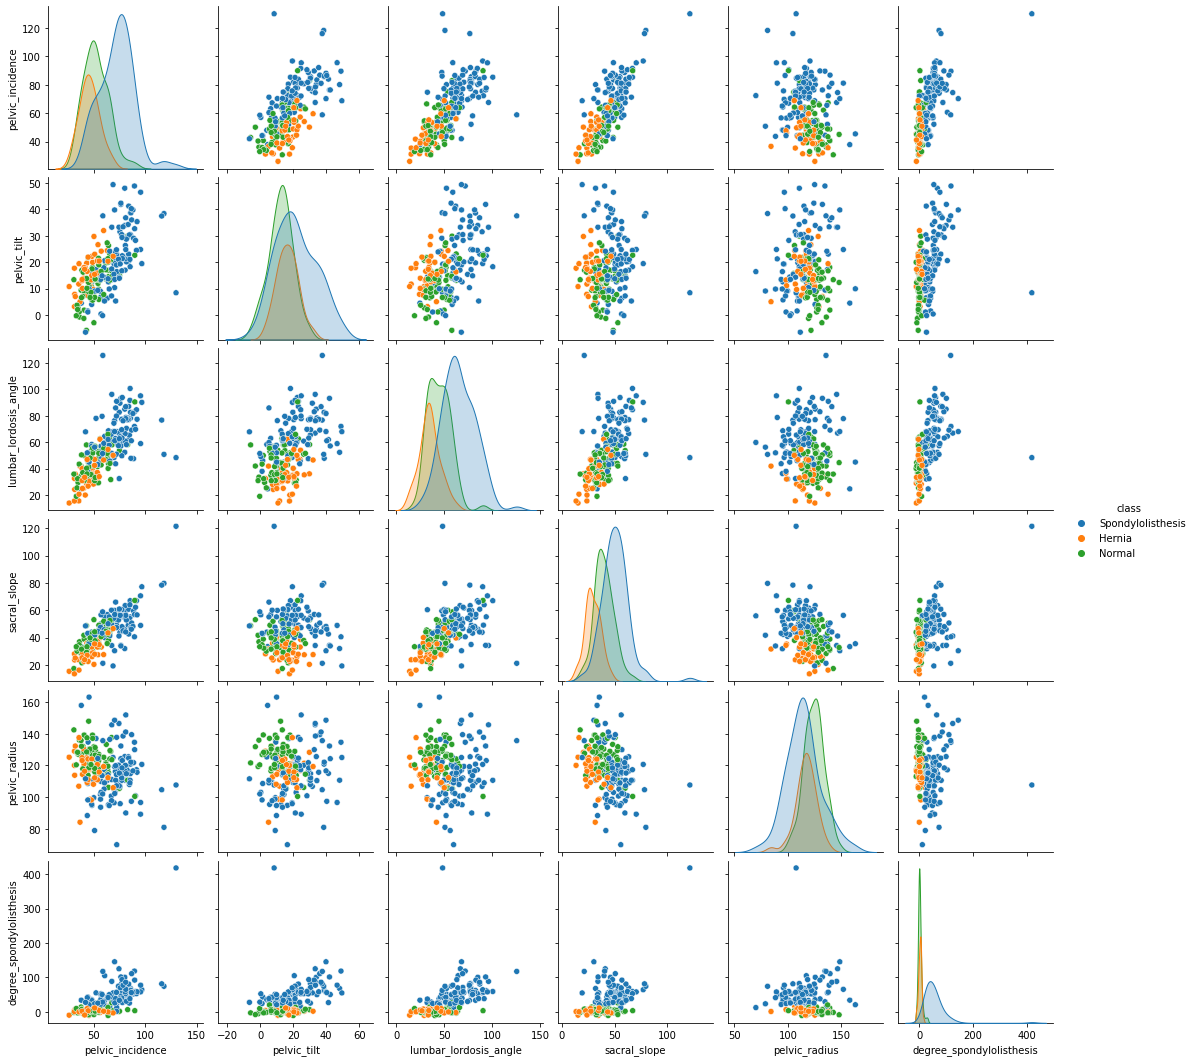

In [89]:
import seaborn as sns
sns.pairplot(pd.read_csv("datasets\\train.csv").drop(['id'],axis=1), hue='class')

## MODEL CREATION

In [90]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from utils.utils import cls_report_file

Obseve no código abaixo que estou fazendo uma validação cruzada (K-fold cross validation). estratificada (cada fold terá a mesma proporção de classes). 

*Probabilisticamente, eu sei que devido ao oversample, a chance de o kfold não estratificado ter gerado folds (partições) com classes (significativamente) desbalanceadas é infinitesimal, mas mesmo assim eu quis forçar a amostragem (garantidamente) estratificada.* 

*StratifiedKFold* divide a base de dados original em **K grupos de dados** e o modelo é treinado e testado em cada divisão (individualmente). <br>

Para saber mais, uma ótima descrição está [aqui](https://vitalflux.com/k-fold-cross-validation-python-example/) e uma imagem ali: <br>

<img src="https://raw.githubusercontent.com/adilsonmedronha/Classification_problems/main/Vertebral%20Column/assets/kfold.png" alt="Drawing" style="width: 400px;"/>

In [106]:
models = []

models.append( ('SVC' , SVC(gamma='auto')))
models.append( ('NB'  , GaussianNB()))
models.append( ('LR'  , LogisticRegression()))
models.append( ('KNN' , KNeighborsClassifier()))
models.append( ('CART', DecisionTreeClassifier()))
models.append( ('LDA',  LinearDiscriminantAnalysis()))

model_names = []
cv_results  = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=4, random_state = 1, shuffle=True)
    cv = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    cls_report_file(name, model, x_train, y_train, x_test, y_test)
    cv_results.append( (cv.mean()*100, name)) 
print(T(sorted(cv_results, reverse=True), headers=["Accuracy %",'Model']))

  Accuracy %  Model
------------  -------
    100       CART
     98.8095  NB
     98.0159  KNN
     98.0159  LDA
     97.2222  SVC
     96.8254  LR


$100\%$ de acurácia através do estimador: árvore de decisão. \o/ <br>

Mais métricas:

                     CART / DECISION TREE: 
                    precision    recall  f1-score   support

           Hernia       1.00      1.00      1.00        25
           Normal       1.00      1.00      1.00        17
           Spondy       1.00      1.00      1.00        21

         accuracy                           1.00        63
        macro avg       1.00      1.00      1.00        63
     weighted avg       1.00      1.00      1.00        63

![](https://raw.githubusercontent.com/adilsonmedronha/Classification_problems/main/Vertebral%20Column/assets/congratulations.gif)

In [67]:
# dimensões
print('Treino:')
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)

print('\nTeste:')
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

Treino:
x_train:  (252, 7)
y_train:  (252,)

Teste:
x_test:  (63, 7)
y_test:  (63,)


Recaptulando, antes do oversample o dataset train.csv tinha $218$ amostras e $7$ features: dimensão $(218, 7)$ <br> 

Com o oversample, passamos a ter $315$ ($252+63$) amostras onde após o split dos dados (80:20) $252$ foi destinado para treino, e $63$ para test 

## Estimadores, ultimato

A seguir fiz um treinamento específico para cada classificador.  <br>
Ordenei a apresentação por ordem de melhor performance nos dados estratificados (Kfold) e então escrevi os arquivos. 

### CART

In [107]:
classifier = DecisionTreeClassifier()
classifier.fit(X_normalized, y_oversampled)
predictions = classifier.predict(test)
df_tosubmit = pd.DataFrame({"id": test_ids,
                            "class": predictions,})
df_tosubmit.to_csv("submissions\submission_CART_OVERSAMPLED_WITH_ID_MIN_MAX_NORMALIZATION.csv", index=False)

Visualizando um pouco a árvore de decisão:

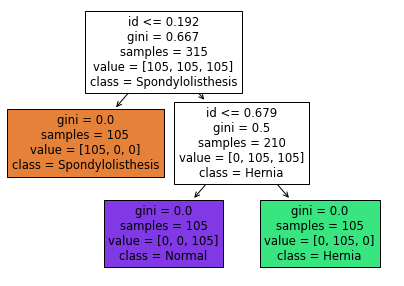

In [108]:
from sklearn import tree
fig = plt.figure(figsize=(7,5))
_ = tree.plot_tree(classifier, 
                   feature_names=df.columns,  
                   class_names=y_oversampled,
                   filled=True)

### NB

In [70]:
classifier = GaussianNB()
classifier.fit(X_normalized, y_oversampled)
predictions = classifier.predict(test)
df_tosubmit = pd.DataFrame({"id": test_ids,
                            "class": predictions,})
df_tosubmit.to_csv("submissions\submission_NB_OVERSAMPLED_WITH_ID_MIN_MAX_NORMALIZATION.csv", index=False)

### LDA

In [71]:
classifier = LinearDiscriminantAnalysis()
classifier.fit(X_normalized, y_oversampled)
predictions = classifier.predict(test)
df_tosubmit = pd.DataFrame({"id": test_ids,
                            "class": predictions,})
df_tosubmit.to_csv("submissions\submission_LDA_OVERSAMPLED_WITH_ID_MIN_MAX_NORMALIZATION.csv", index=False)

### SVC

In [72]:
classifier = SVC()
classifier.fit(X_normalized, y_oversampled)
predictions = classifier.predict(test)
df_tosubmit = pd.DataFrame({"id": test_ids,
                            "class": predictions,})
df_tosubmit.to_csv("submissions\submission_SVC_OVERSAMPLED_WITH_ID_MIN_MAX_NORMALIZATION.csv", index=False)

### LR

In [73]:
classifier = LogisticRegression()
classifier.fit(X_normalized, y_oversampled)
predictions = classifier.predict(test)
df_tosubmit = pd.DataFrame({"id": test_ids,
                            "class": predictions,})
df_tosubmit.to_csv("submissions\submission_LR_OVERSAMPLED_WITH_ID_MIN_MAX_NORMALIZATION.csv", index=False)

### KNN

In [74]:
classifier = KNeighborsClassifier()
classifier.fit(X_normalized, y_oversampled)
predictions = classifier.predict(test)
df_tosubmit = pd.DataFrame({"id": test_ids,
                            "class": predictions,})
df_tosubmit.to_csv("submissions\submission_KNN_OVERSAMPLED_WITH_ID_MIN_MAX_NORMALIZATION.csv", index=False)

**Obrigado, <br> Adilson**